In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import uncertainties as un
import uncertainties.unumpy as unp
from uncertainties.unumpy import nominal_values, std_devs
err = std_devs
nom = nominal_values

from li_funks.plot import savefig  # function to save pdf and png figures
from li_funks.plot import rdict, mdict  # dictionaries of markers and colors for each study.
from li_funks.plot import plot_line, fit_line  # functions to plot lines and fit lines

In [40]:
df = pd.read_pickle('data/processed_LiDataFull.pkl')  # use pickle to preserve uncertainty info
sdf = pd.read_pickle('data/processed_LiDataSummary.pkl')  # use pickle to preserve uncertainty info

## Plot Parameters

In [41]:
database = 'pitzer'  # which solution chemistry calculation to use -- minteq.v4 or pitzer

cdict = {
    'Control': 'C1',
    'T': 'grey',
    'DIC': 'C2',
    'pH': 'C0'
}

## Results 0: Experimental Matrix

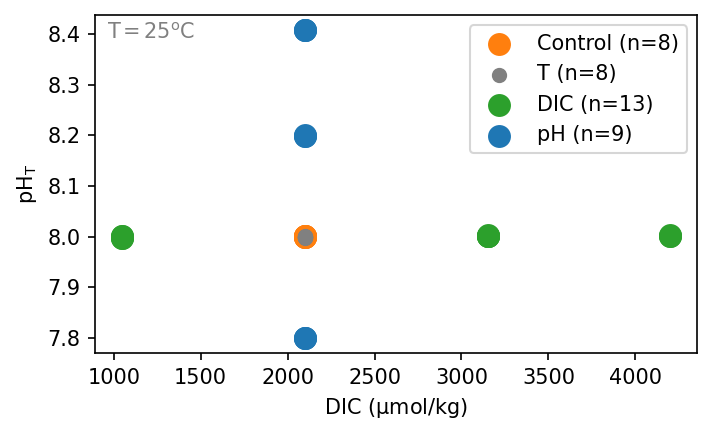

In [42]:
fig, ax = plt.subplots(1, 1)

for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    s = 100
    if e == 'T':
        s = 40
    ax.scatter(df.loc[ind, (database, 'C(mol/kgw)')] * 1e6, df.loc[ind, (database, 'pH')], label=f'{e} (n={sum(ind)})', color=c, s=s)

ax.text(.02, .98, '$T=25^oC$', va='top', ha='left', color=(.5,.5,.5), transform=ax.transAxes)
ax.legend(fontsize=10)

ax.set_ylabel('$pH_T$')
ax.set_xlabel('DIC ($\mu mol/kg$)')

fig.tight_layout()

## Results 1: Individual effects

In [43]:
xvar = 'pH'
if xvar == 'C(mol/kgw)':
    m = 1e6
    v = 'DIC'
elif xvar == 'pH':
    m = 1
    v = 'pH'
elif xvar == 'temp(C)':
    m = 1
    v = 'T'
else:
    vind = np.ones(df.shape[0], dtype=bool)
    m = 1
vind = df.labels.Experiment.str.contains(v)

In [44]:
xvar = 'temp(C)'
control_grp = df.loc[vind, ('labels', 'Control')].unique().item()

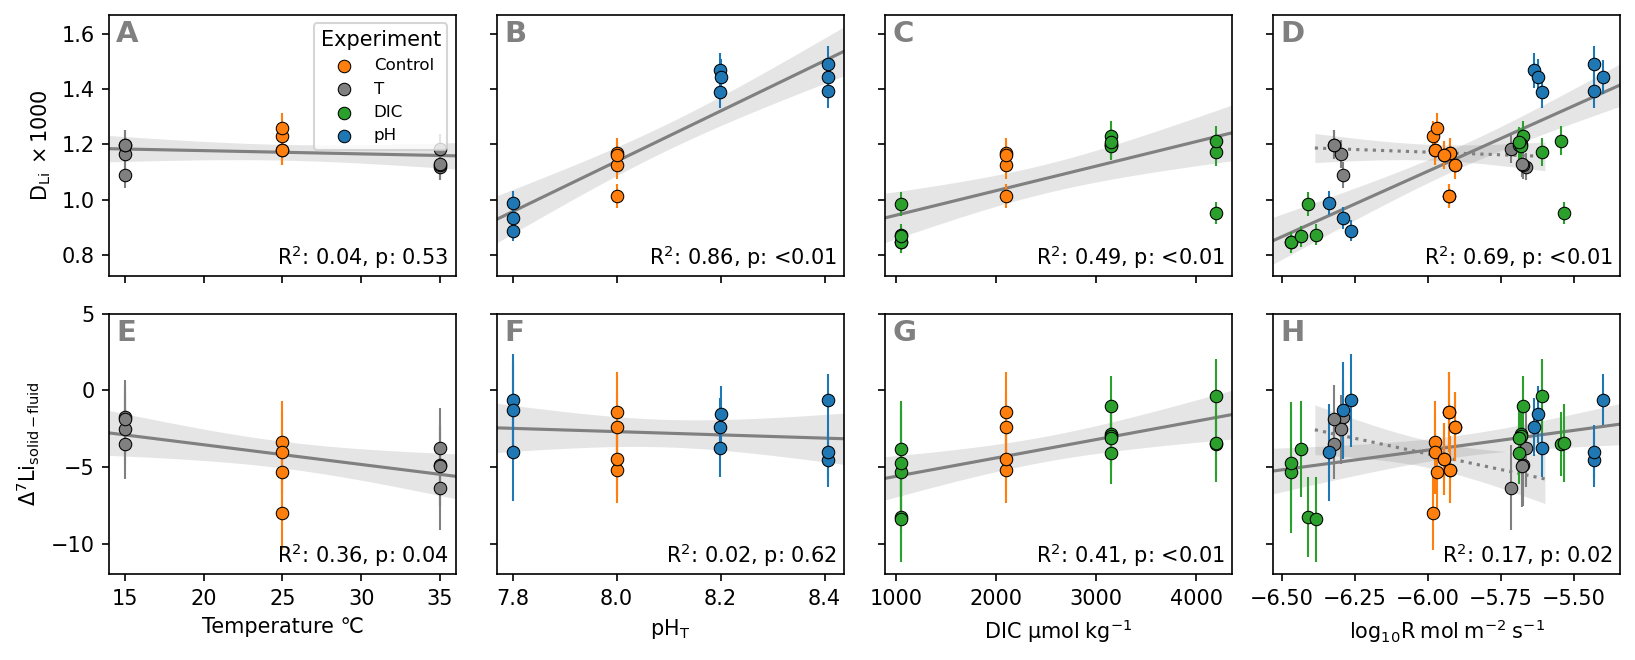

In [45]:
fig, axs = plt.subplots(2, 4, sharey='row', sharex='col', figsize=[11, 4.5])
# fig, axs = plt.subplots(2, 5, figsize=(14, 5), sharey='row', sharex='col')

axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\Delta^7Li_{solid-fluid}$')
rdax, rpax = axs[:, -1]

for i, xvar in enumerate(['temp(C)', 'pH', 'C(mol/kgw)']):
    dax, pax = axs.T[i]
    if xvar == 'C(mol/kgw)':
        m = 1e6
        v = 'DIC'
    elif xvar == 'pH':
        m = 1
        v = 'pH'
    elif xvar == 'temp(C)':
        m = 1
        v = 'T'
    else:
        vind = np.ones(df.shape[0], dtype=bool)
        m = 1

    vind = df.labels.Experiment.str.contains(v)
    control_grp = df.loc[vind, ('labels', 'Control')].unique().item()
    cind = df.labels.Experiment.str.contains(f'Control{control_grp:.0f}')
    color = cdict[v]
    lw=0.5
        
    for ind, c in zip([vind, cind], [color, cdict['Control']]):
        dax.errorbar(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     xerr=err(df.loc[ind, (database, xvar)]) * m, yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=0, elinewidth=1, color=c, zorder=-1)
        dax.scatter(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                    lw=lw, edgecolor='k', color=c, zorder=1)
                
        pax.errorbar(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                     xerr=err(df.loc[ind, (database, xvar)]) * m, yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                     lw=0, elinewidth=1, color=c, zorder=-1)
        pax.scatter(nom(df.loc[ind, (database, xvar)]) * m, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                    lw=lw, edgecolor='k', color=c, zorder=1)
        
        rdax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                      xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                      lw=0, elinewidth=1, color=c, zorder=-1)
        rdax.scatter(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=lw, edgecolor='k', color=c, zorder=1)
        rpax.errorbar(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                      xerr=err(df.loc[ind, ('R', 'log10R_13C')]), yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                      lw=0, elinewidth=1, color=c, zorder=-1)
        rpax.scatter(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                     lw=lw, edgecolor='k', color=c, zorder=1)
        
    dp = fit_line(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
    dreg = stats.linregress(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3)
    plot_line(dax, dp, zorder=-3, color='gray')
    ptext = f'{dreg.pvalue:.2f}' if dreg.pvalue > 0.01 else '<0.01'
    dax.text(0.98, 0.02, f'$R^2$: {dreg.rvalue**2:.2f}, p: {ptext}', transform=dax.transAxes, ha='right', va='bottom')
    
    pp = fit_line(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'Delta_og')]))
    preg = stats.linregress(df.loc[vind | cind, (database, xvar)] * m, nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'Delta_og')]))
    plot_line(pax, pp, zorder=-3, color='gray')
    ptext = f'{preg.pvalue:.2f}' if preg.pvalue > 0.01 else '<0.01'
    pax.text(0.98, 0.02, f'$R^2$: {preg.rvalue**2:.2f}, p: {ptext}', transform=pax.transAxes, ha='right', va='bottom')
    
axs[1,0].set_xlabel('Temperature ℃')
axs[1,1].set_xlabel('$pH_T$')
axs[1,2].set_xlabel('DIC $\mu mol~kg^{-1}$')
axs[1,3].set_xlabel('$log_{10}R~mol~m^{-2}~s^{-1}$')

ind = ~df.labels.Experiment.str.contains('T')
dp = fit_line(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3)
dreg = stats.linregress(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('OG', 'DLi')]) * 1e3)
plot_line(rdax, dp, zorder=-3, color='gray')
ptext = f'{dreg.pvalue:.2f}' if dreg.pvalue > 0.01 else '<0.01'
rdax.text(0.98, 0.02, f'$R^2$: {dreg.rvalue**2:.2f}, p: {ptext}', transform=rdax.transAxes, ha='right', va='bottom')

pp = fit_line(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]))
preg = stats.linregress(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]))
plot_line(rpax, pp, zorder=-3, color='gray')
ptext = f'{preg.pvalue:.2f}' if preg.pvalue > 0.01 else '<0.01'
rpax.text(0.98, 0.02, f'$R^2$: {preg.rvalue**2:.2f}, p: {ptext}', transform=rpax.transAxes, ha='right', va='bottom')

rpax.set_ylim(-12, 5)

# draw on temperature lines

xvar == 'temp(C)'
m = 1
v = 'T'
vind = df.labels.Experiment.str.contains(v)
control_grp = df.loc[vind, ('labels', 'Control')].unique().item()
cind = df.labels.Experiment.str.contains(f'Control{control_grp:.0f}')
color = cdict[v]
lw=0.5

R = nom(df.loc[vind | cind, ('R', 'log10R_13C')])
DLi = nom(df.loc[vind | cind, ('OG', 'DLi')]) * 1e3
epsLi = nom(df.loc[vind | cind, ('Li_isotopes_vs_fluid', 'Delta_og')])

Rrng = np.ptp(R)
nR = np.linspace(R.min() - 0.1 * Rrng, R.max() + 0.1 * Rrng, 30)

pp = fit_line(R, DLi)
plot_line(rdax, pp, xn=nR, zorder=-3, color='gray', ls=':')

pp = fit_line(R, epsLi)
plot_line(rpax, pp, xn=nR, zorder=-3, color='gray', ls=':')

 
for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

for label in cdict:
    axs[0,0].scatter([], [], label=label, color=cdict[label], lw=lw, edgecolor='k')

axs[0,0].legend(fontsize=8, title='Experiment')

# axs[1,0].set_ylim(-9, 0)
fig.tight_layout()

savefig(fig, '01_IndividualEffects')

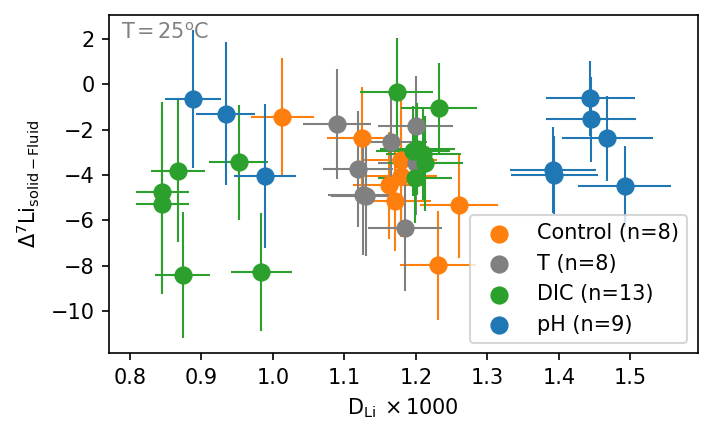

In [46]:
fig, ax = plt.subplots(1, 1)

for e, c in cdict.items():
    ind = df.labels.Experiment.str.contains(e)
    s = 60

    ax.scatter(nom(df.loc[ind, ('OG', 'DLi')]) * 1e3, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]), label=f'{e} (n={sum(ind)})', color=c, s=s)
    ax.errorbar(nom(df.loc[ind, ('OG', 'DLi')]) * 1e3, nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                xerr=err(df.loc[ind, ('OG', 'DLi')]) * 1e3, yerr=err(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                lw=0, elinewidth=1, color=c, zorder=-1)
    
ax.text(.02, .98, '$T=25^oC$', va='top', ha='left', color=(.5,.5,.5), transform=ax.transAxes)
ax.legend(fontsize=10)

ax.set_ylabel('$\Delta^7Li_{solid-Fluid}$')
ax.set_xlabel('$D_{Li}\ \\times 1000$')

fig.tight_layout()

## 2. Comparison to Previous

In [47]:
lit = pd.read_pickle('data/processed_LiDataLiterature.pkl')


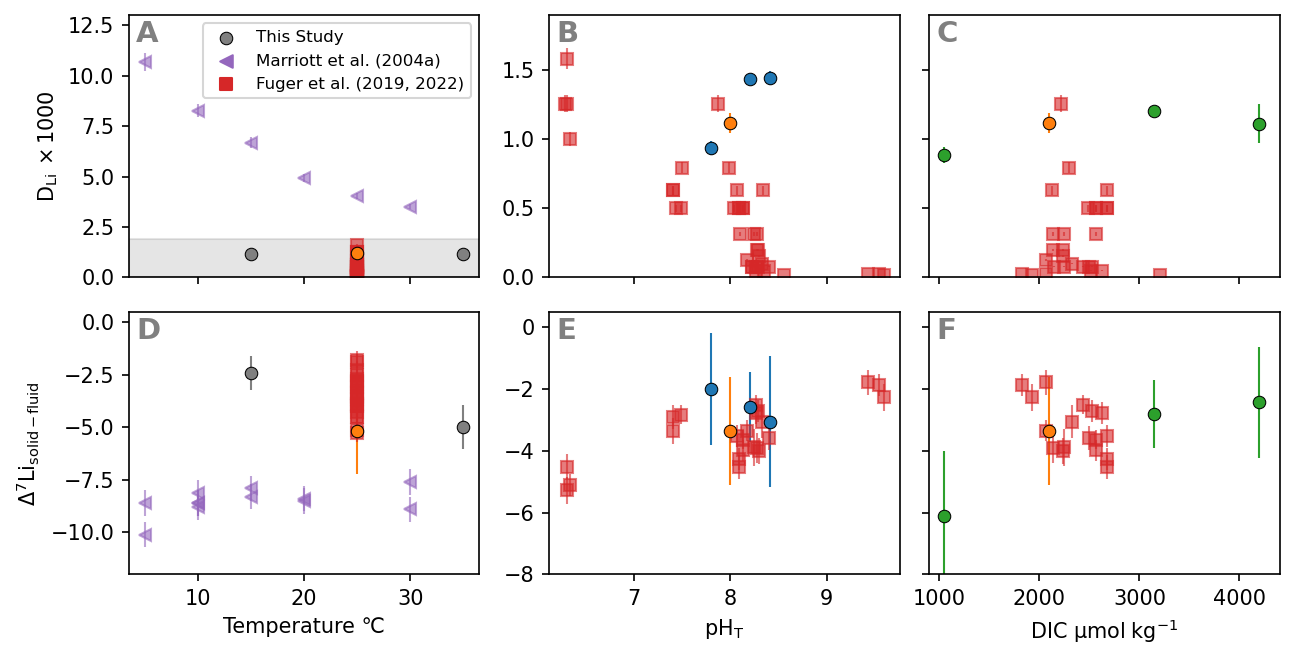

In [48]:
inorg = lit.loc['calcite']
epar = {'lw': 0,
        'elinewidth': 1,
        'alpha': 0.6}

# fig, axs = plt.subplots(2, 3, sharey=False, sharex='col', figsize=[9, 4.5], constrained_layout=True)
fig = plt.figure(figsize=[9, 4.5])
gs = GridSpec(2, 3, fig)

p00 = fig.add_subplot(gs[0, 0])
p10 = fig.add_subplot(gs[1, 0], sharex=p00)

p01 = fig.add_subplot(gs[0, 1])
p11 = fig.add_subplot(gs[1, 1], sharex=p01)

p02 = fig.add_subplot(gs[0, 2], sharey=p01)
p12 = fig.add_subplot(gs[1, 2], sharey=p11, sharex=p02)

axs = np.array([[p00, p10],[p01, p11],[p02, p12]]).T


for i, xvar in enumerate(['temp(C)', 'pH', 'C(mol/kgw)']):
    dax, pax = axs.T[i]
    if xvar == 'C(mol/kgw)':
        m = 1e6
        v = 'DIC'
    elif xvar == 'pH':
        m = 1
        v = 'pH'
    elif xvar == 'temp(C)':
        m = 1
        v = 'T'
    else:
        vind = np.ones(sdf.shape[0], dtype=bool)
        m = 1

    vind = sdf.index.str.contains(v)
    control_grp = nom(sdf.loc[vind, ('labels', 'Control')].unique().item())
    cind = sdf.index.str.contains(f'Control{control_grp:.0f}')
    # cind = sdf.index.str.contains('Control')
    color = cdict[v]
    lw=0.5
        
    for ind, c in zip([vind, cind], [color, cdict['Control']]):
        dax.errorbar(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                     xerr=err(sdf.loc[ind, (database, xvar)]) * m, yerr=err(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                     lw=0, elinewidth=1, color=c, zorder=-1)
        dax.scatter(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('OG', 'DLi')]) * 1e3,
                    lw=lw, edgecolor='k', color=c, zorder=20)
                
        pax.errorbar(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                     xerr=err(sdf.loc[ind, (database, xvar)]) * m, yerr=err(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                     lw=0, elinewidth=1, color=c, zorder=-1)
        pax.scatter(nom(sdf.loc[ind, (database, xvar)]) * m, nom(sdf.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]),
                    lw=lw, edgecolor='k', color=c, zorder=20)
        
axs[0,0].scatter([],[], c='grey', label='This Study', edgecolor='k', lw=0.5)

whos = ['Marriott2004a', 'Fuger2019']
for who in whos:
    c, m = mdict[who]
    
    dax, pax = axs.T[0]
    dax.errorbar(inorg.loc[who, ('solution', 'TempC')], inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                    yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                    marker=m, color=c, **epar)
    pax.errorbar(inorg.loc[who, ('solution', 'TempC')], inorg.loc[who, ('solid', 'Delta_7Li')], 
                    yerr=inorg.loc[who, ('solid', 'Delta_7Li_2std')],
                    marker=m, color=c, **epar)
        
    if 'Fuger' in who:
        dax, pax = axs.T[1]
        dax.errorbar(inorg.loc[who, (database, 'pH')], inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, (database, 'pH')], inorg.loc[who, ('solid', 'Delta_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'Delta_7Li_2std')],
                     marker=m, color=c, **epar)
        
        dax, pax = axs.T[2]
        dax.errorbar(inorg.loc[who, (database, 'C(mol/kgw)')] * 1e6, inorg.loc[who, ('solid', 'DLi')] * 1e3, 
                     yerr=inorg.loc[who, ('solid', 'DLi_2std')] * 1e3,
                     marker=m, color=c, **epar)
        pax.errorbar(inorg.loc[who, (database, 'C(mol/kgw)')] * 1e6, inorg.loc[who, ('solid', 'Delta_7Li')], 
                     yerr=inorg.loc[who, ('solid', 'Delta_7Li_2std')],
                     marker=m, color=c, **epar)

    axs[0,0].scatter([], [], marker=m, color=c, label=rdict[who])
                    
axs[0,0].legend(fontsize=8)

axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\Delta^7Li_{solid-fluid}$')

axs[1,0].set_xlabel('Temperature ℃')
axs[1,1].set_xlabel('$pH_T$')
axs[1,2].set_xlabel('DIC $\mu mol~kg^{-1}$')

axs[1,2].set_xlim(900, 4400)

axs[0,0].set_ylim(0, 13)
axs[0,1].set_ylim(0, 1.9)

axs[1,0].set_ylim(-12, 0.5)
axs[1,1].set_ylim(-8, 0.5)

for ax in axs[0,:]:
    plt.setp(ax.get_xticklabels(), visible=False)

for ax in axs[:, 2]:
    plt.setp(ax.get_yticklabels(), visible=False)

fig.tight_layout()

for ax in axs[:, 2]:
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.03, pos.y0,  pos.width, pos.height])

axs[0,0].axhspan(*axs[0,1].get_ylim(), color='grey', alpha=0.2)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

savefig(fig, '02_PublishedComparison')

## 3. Rate Plots

In [49]:
fug = inorg.loc['Fuger2019', :]
epar = {'lw': 0,
        'elinewidth': 1}

In [50]:
combined_epsLi = np.concatenate([unp.uarray(fug.loc[:, ('solid', 'Delta_7Li')], fug.loc[:, ('solid', 'Delta_7Li_2std')]), df.Li_isotopes_vs_fluid.Delta_og])
combined_epsLi = combined_epsLi[~unp.isnan(combined_epsLi)]
epsLi_mu = combined_epsLi.mean()
epsLi_mu, combined_epsLi.size

(-3.571953358355057+/-1.4077341402736157, 61)

In [51]:
def SKM(Rp, Kf, Keq, log10Rb=-7):
    """
    DePaolo's (2011) Surface Kinetic Model
    
    Parameters
    ----------
    Kf : array-like
        The kinetic ('forward') fractionation factor.
        Kp will asymptote towards this value at high
        Rp.
    Keq : array-like
        The equilibrium fractionation factor. Kp will
        asymptote towards this values at low Rp.
    Rp : array-like
        Precipitation rate.
    Rb : array-like
        Ion detachment rate.

    Returns
    -------
    Kp : array-like
        Partitioning / fractionation of element in precipitated mineral.
    """
    Rb = 10**log10Rb
    return Kf / (1 + Rb * (Kf / Keq - 1) / (Rp + Rb))


In [52]:
# fit data with ~constant HCO3- activity
Rp = np.concatenate([nom(df.R.R_13C), nom(10**fug.solid.logR)])
la_HCO3 = np.concatenate([df[database, 'la_HCO3-'].values, fug[database, 'la_HCO3-'].values])
HCO3 = 10**la_HCO3

DLi = np.concatenate([nom(df.OG.DLi), nom(fug.solid.DLi)])
DLi_err = np.concatenate([err(df.OG.DLi), fug.solid.DLi_2std * 2])

ind = np.isclose(la_HCO3, df[database, 'la_HCO3-'].values.mean(), atol=0.05)

p, cov = curve_fit(SKM, Rp[ind], DLi[ind], p0=[1.5e-3, 0.5e-6, -9.], method='trf')
up = un.correlated_values(p, cov)

nR = np.logspace(-8.3, -5.3)
pred = SKM(nR, *up)

In [53]:
df[database, 'la_HCO3-'].values.mean()

-2.72870967393008

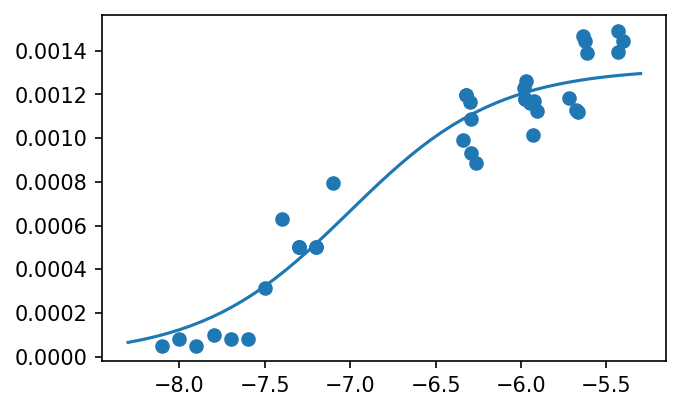

In [54]:
plt.scatter(np.log10(Rp[ind]), DLi[ind])
plt.plot(np.log10(nR), nom(pred))

/tmp/ipykernel_21293/3318206273.py:100: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[0,0].scatter([],[],marker='o', label='This Study', color='w', **cargs)
/tmp/ipykernel_21293/3318206273.py:101: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  axs[0,0].scatter([],[],marker='s', label='Fuger et al. (2019, 2022)', color='w', **cargs)


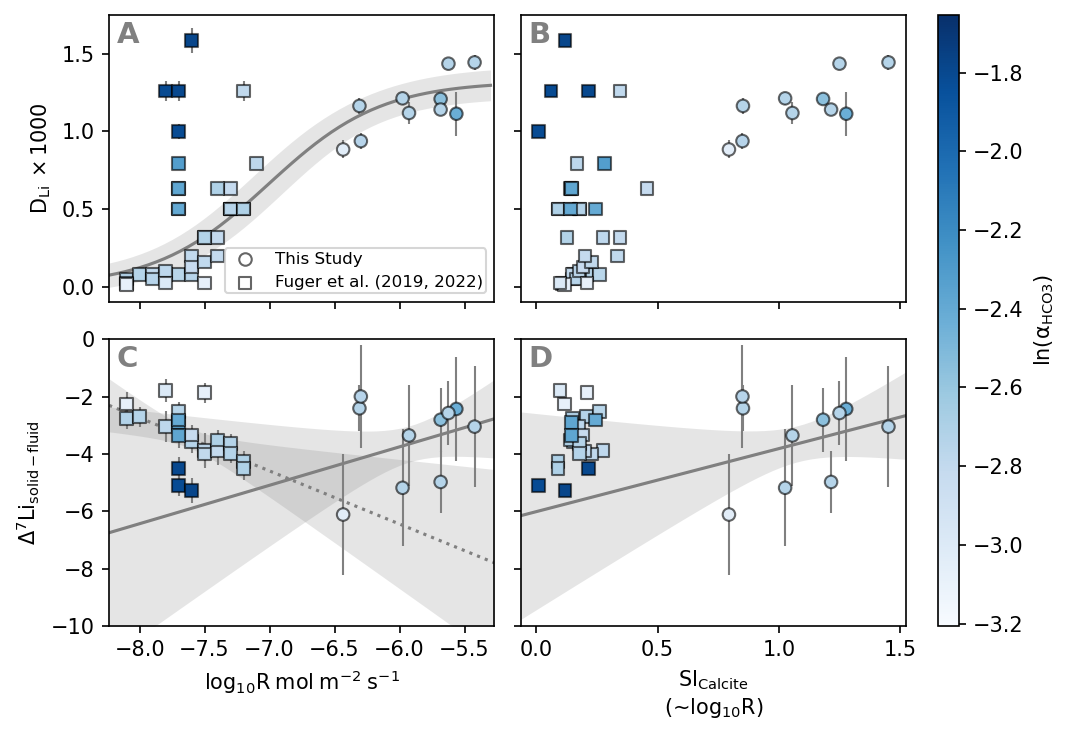

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex='col', sharey='row')

pdf = sdf
cvar = (database, 'la_HCO3-')
clabel = r'$ln(\alpha_{HCO3})$'

# logR plot

bax, pax = axs[:,0]

pax.set_xlabel('$log_{10}R~mol~m^{-2}~s^{-1}$')

clim = np.concatenate([fug.loc[:, cvar].values, pdf.loc[:, cvar].values])
cargs = {
    'vmin': np.nanmin(clim) - np.ptp(clim) * 0.1,
    'vmax': np.nanmax(clim) + np.ptp(clim) * 0.1,
    'cmap': plt.cm.Blues,
    'lw': 1,
    'edgecolor': (0,0,0,.6)
}

bax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=fug.loc[:, ('solid', 'DLi_2std')] * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

pax.errorbar(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'Delta_7Li')],
             yerr=fug.loc[:, ('solid', 'Delta_7Li_2std')],
             **epar, zorder=-1, color='grey')
pax.scatter(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'Delta_7Li')], 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.loc[:, cvar]), **cargs)

pax.errorbar(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'Delta_og')]),
             xerr=err(pdf.loc[:, ('R', 'log10R_13C')]), yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'Delta_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, ('R', 'log10R_13C')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'Delta_og')]), c=nom(pdf.loc[:, cvar]), **cargs)

# SI Calcite plot

bax, pax = axs[:,1]

pax.set_xlabel('$SI_{Calcite}$\n(~$log_{10}R$)')

bax.errorbar(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'DLi')] * 1e3,
             yerr=err(fug.loc[:, ('solid', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'DLi')] * 1e3, 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

pax.scatter(fug.loc[:, (database, 'si_Calcite')], fug.loc[:, ('solid', 'Delta_7Li')], 
            c=fug.loc[:, cvar], marker=mdict['Fuger2019'][1], **cargs)

bax.errorbar(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             yerr=err(pdf.loc[:, ('OG', 'DLi')]) * 1e3,
             **epar, zorder=-1, color='grey')
bax.scatter(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('OG', 'DLi')]) * 1e3, c=nom(pdf.loc[:, cvar]), **cargs)

pax.errorbar(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'Delta_og')]),
             yerr=err(pdf.loc[:, ('Li_isotopes_vs_fluid', 'Delta_og')]),
             **epar, zorder=-1, color='grey')
ma = pax.scatter(nom(pdf.loc[:, (database, 'si_Calcite')]), nom(pdf.loc[:, ('Li_isotopes_vs_fluid', 'Delta_og')]), c=nom(pdf.loc[:, cvar]), **cargs)

# pax.set_xlim(-6.6, -5.3)
pax.set_ylim(-10, 0.)

# draw on lines of best fit for the fuger data and our data
pp = fit_line(fug.loc[:, ('solid', 'logR')], fug.loc[:, ('solid', 'Delta_7Li')])
plot_line(axs[1,0], pp, zorder=-3, color='gray', ls=':')

ind = ~df.index.str.contains('T =')
pp = fit_line(nom(df.loc[ind, ('R', 'log10R_13C')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]))
plot_line(axs[1,0], pp, zorder=-3, color='gray')

pp = fit_line(nom(df.loc[ind, (database, 'si_Calcite')]), nom(df.loc[ind, ('Li_isotopes_vs_fluid', 'Delta_og')]))
plot_line(axs[1,1], pp, zorder=-3, color='gray')

# draw on SKM fit to constant HCO3-
axs[0,0].plot(np.log10(nR), unp.nominal_values(pred) * 1000, color='grey', zorder=-2)
axs[0,0].fill_between(np.log10(nR), unp.nominal_values(pred - 1.96 * err(pred)) * 1000, unp.nominal_values(pred + 1.96 * err(pred)) * 1000, alpha=0.2, color='grey', zorder=-3, lw=0)


axs[0,0].set_ylabel('$D_{Li}\ \\times 1000$')
axs[1,0].set_ylabel('$\Delta^7Li_{solid-fluid}$')

fig.tight_layout()

fig.subplots_adjust(right=0.87)
cax = fig.add_axes([.9, pax.get_position().y0, .02, bax.get_position().y1 - pax.get_position().y0])
fig.colorbar(ma, cax, label=clabel)

for ax, a in zip(axs.flat, 'ABCDEFGH'):
    ax.text(0.02, 0.98, a, weight='bold', transform=ax.transAxes, ha='left', va='top', fontsize=14, color='grey')

axs[0,0].scatter([],[],marker='o', label='This Study', color='w', **cargs)
axs[0,0].scatter([],[],marker='s', label='Fuger et al. (2019, 2022)', color='w', **cargs)
axs[0,0].legend(fontsize=8, borderpad=0.2)

savefig(fig, '03_Rate_SI')

## 4. Plot SKM residuals against ion activity products.

In [56]:
dpred = SKM(Rp, *up)
resid = DLi - dpred
y = resid


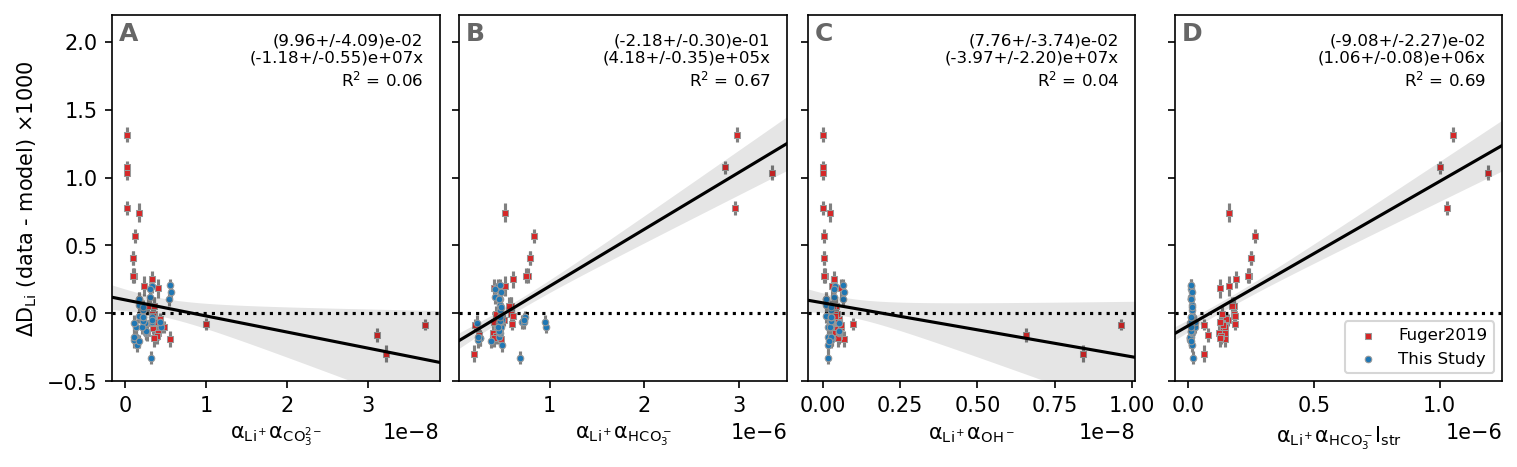

In [57]:
# isolate useful solution variables
mu = np.concatenate([df[database, 'mu'].values, fug[database, 'mu'].values])  # ionic strength
la_OH = np.concatenate([df[database, 'la_OH-'].values, fug[database, 'la_OH-'].values])
la_HCO3 = np.concatenate([df[database, 'la_HCO3-'].values, fug[database, 'la_HCO3-'].values])
la_CO3 = np.concatenate([df[database, 'la_CO3-2'].values, fug[database, 'la_CO3-2'].values])
la_Li = np.concatenate([df[database, 'la_Li+'].values, fug[database, 'la_Li+'].values])

# keep track of which study the combined data are from
study = np.concatenate([np.full(df.shape[0], 'This Study'), np.full(fug.shape[0], 'Fuger2019')])

# calculate solution ion activity products
Li_CO3 = 10**la_Li * 10**la_CO3
Li_HCO3 = 10**la_Li * 10**la_HCO3
Li_HCO3_mu = 10**la_Li * 10**la_HCO3 * mu
Li_OH = 10**la_Li * 10**la_OH

xvars = [
    (Li_CO3, r'$\alpha_{Li^+} \alpha_{CO_3^{2-}}$'),
    (Li_HCO3, r'$\alpha_{Li^+} \alpha_{HCO_3^-}$'),
    (Li_OH, r'$\alpha_{Li^+} \alpha_{OH^-}$'),
    (Li_HCO3_mu, r'$\alpha_{Li^+} \alpha_{HCO_3^-} I_{str}$'),
    ]

cvar = None
copts = {}

# make plot

fig, axs = plt.subplots(1, len(xvars), figsize=[2.5 * len(xvars), 3], sharey=True, constrained_layout=True)

labels = 'ABCD'

for i, (xv, label) in enumerate(xvars):
    ax = axs[i]
    # for s in ['Fuger2019']:
    for s in np.unique(study):
        ind = study == s

        c, m = mdict[s]
        
        ax.scatter(xv[ind], nom(y[ind]) * 1e3, s=10, c=c, marker=m, lw=0.5, edgecolor=(.6,.6,.6), **copts, label=s)
        ax.errorbar(xv[ind], nom(y[ind]) * 1e3, yerr=err(y[ind]) * 1e3, fmt='none', c='grey', zorder=-3)
        ax.set_xlabel(label)
        
    up = un.correlated_values(*np.polyfit(xv, nom(y) * 1e3, 1, cov=True))
    
    xlim = ax.get_xlim()
    ax.set_xlim(xlim)
    xn = np.linspace(*xlim)
    pred = np.polyval(up, xn)
    
    r2 = r2_score(nom(y) * 1e3, nom(np.polyval(up, xv)))
    
    ax.plot(xn, nom(pred), color='k')
    ax.fill_between(xn, nom(pred) - 1.96 * err(pred), nom(pred) + 1.96 * err(pred), alpha=0.1, color='k', lw=0)
    ax.text(0.95, 0.95, f'{up[1]:.2e}\n{up[0]:.2e}x\n$R^2$ = {r2:.2f}', transform=ax.transAxes, va='top', ha='right', fontsize=8)
    ax.text(0.02, 0.98, labels[i], transform=ax.transAxes, va='top', ha='left', fontsize=12, weight='bold', color=(.4,.4,.4))
    
axs[0].set_ylim(-0.5, 2.2)
    
axs[0].set_ylabel('$\Delta D_{Li}$ (data - model) $\\times 1000$')

axs[-1].legend(fontsize=8, loc='lower right')

for ax in axs:
    ax.axhline(0, ls=':', c='k', zorder=-1)
    
savefig(fig, '04_Rate_Residuals')